In [1]:
%matplotlib widget

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.style.use('seaborn-v0_8')


trade_files = [
    ('./trades_round_5_day_2.csv', 2),
    ('./trades_round_5_day_3.csv', 3),
    ('./trades_round_5_day_4.csv', 4),
]


# Load and preprocess each day's data
dfs = []
for filepath, day in trade_files:
    df_day = pd.read_csv(filepath, sep=';')
    df_day['absolute_timestamp'] = df_day['timestamp'] + (day - 2) * 1_000_000
    df_day['timestamp'] = df_day['absolute_timestamp']
    df_day['tick'] = df_day['absolute_timestamp'] // 100
    df_day['day'] = day
    dfs.append(df_day)

# Concatenate into a single DataFrame
combined = pd.concat(dfs, ignore_index=True)

# Display basic info and sample
print("Combined shape:", combined.shape)
combined.tail()

Combined shape: (53477, 10)


timestamp    buyer  seller         symbol   currency    price  \
53472    2999600   Caesar   Pablo  VOLCANIC_ROCK  SEASHELLS  10104.0   
53473    2999700  Charlie   Paris           KELP  SEASHELLS   2011.0   
53474    2999700  Charlie   Paris      SQUID_INK  SEASHELLS   1899.0   
53475    2999700    Peter  Caesar  VOLCANIC_ROCK  SEASHELLS  10107.0   
53476    2999800   Caesar   Paris        DJEMBES  SEASHELLS  13409.0   

       quantity  absolute_timestamp   tick  day  
53472         2             2999600  29996    4  
53473         1             2999700  29997    4  
53474         1             2999700  29997    4  
53475        10             2999700  29997    4  
53476         2             2999800  29998    4

In [3]:
price_files = [
    './prices_round_5_day_2.csv',
    './prices_round_5_day_3.csv',
    './prices_round_5_day_4.csv'
]

day_offsets = {
    0: 0,
    1: 1_000_000,
    2: 2_000_000,
    #3: 3_000_000,
    #4: 4_000_000,
    #5: 5_000_000,
    #6: 6_000_000,
    #7: 7_000_000
}

dfs = []

for i, file in enumerate(price_files):
    df = pd.read_csv(file)
    df = df.iloc[:, 0].str.split(";", expand=True)
    df.columns = [
        "day", "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss"
    ]
    
    # Convert numeric columns
    numeric_cols = df.columns.difference(["day", "timestamp", "product"])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Convert and shift timestamp
    df["timestamp"] = df["timestamp"].astype(int) + day_offsets[i]
    
    dfs.append(df)

# Concatenate all days into one dataframe
df = pd.concat(dfs, ignore_index=True)

In [4]:
unique_buyers = combined['buyer'].unique()
unique_sellers = combined['seller'].unique()

buyers_list = []
sellers_list = []

for buyer in unique_buyers:
    buyers_list.append(buyer)

for seller in unique_sellers:
    sellers_list.append(seller)

print(buyers_list)
print(sellers_list)

['Caesar', 'Charlie', 'Paris', 'Camilla', 'Pablo', 'Penelope', 'Gary', 'Peter', 'Gina', 'Olivia']
['Paris', 'Caesar', 'Charlie', 'Gina', 'Gary', 'Pablo', 'Camilla', 'Peter', 'Penelope', 'Olivia', 'Olga']


In [5]:
def plot_product_trades(product_df, trade_df, product_name, buyer, seller):
    # filter product mid‑price
    product_data = product_df[product_df['product'] == product_name]
    
    # filter for any trade by either counterparty
    p_trades = trade_df[
        (trade_df['symbol'] == product_name) &
        ((trade_df['buyer'] == buyer) | (trade_df['seller'] == seller))
    ]
    
    # if no trades for either side, skip plotting entirely
    if p_trades.empty:
        # you could log or print if you want:
        # print(f"No trades for {buyer}/{seller} on {product_name}, skipping.")
        return
    
    plt.figure(figsize=(12, 6))
    
    # plot mid price
    plt.plot(
        product_data['timestamp'],
        product_data['mid_price'],
        label=f'{product_name} Mid Price',
        color='black',
        linewidth=2
    )
    
    # plot buyer trades
    buys = p_trades[p_trades['buyer'] == buyer]
    if not buys.empty:
        plt.scatter(
            buys['timestamp'],
            buys['price'],
            label=f'{buyer} Buys',
            color='blue',
            marker='o'
        )
    
    # plot seller trades
    sells = p_trades[p_trades['seller'] == seller]
    if not sells.empty:
        plt.scatter(
            sells['timestamp'],
            sells['price'],
            label=f'{seller} Sells',
            color='red',
            marker='x'
        )
    
    # labels, grid, legend
    plt.title(f"Mid Price vs Trades for {product_name}")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

/tmp/ipykernel_565639/4001612402.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


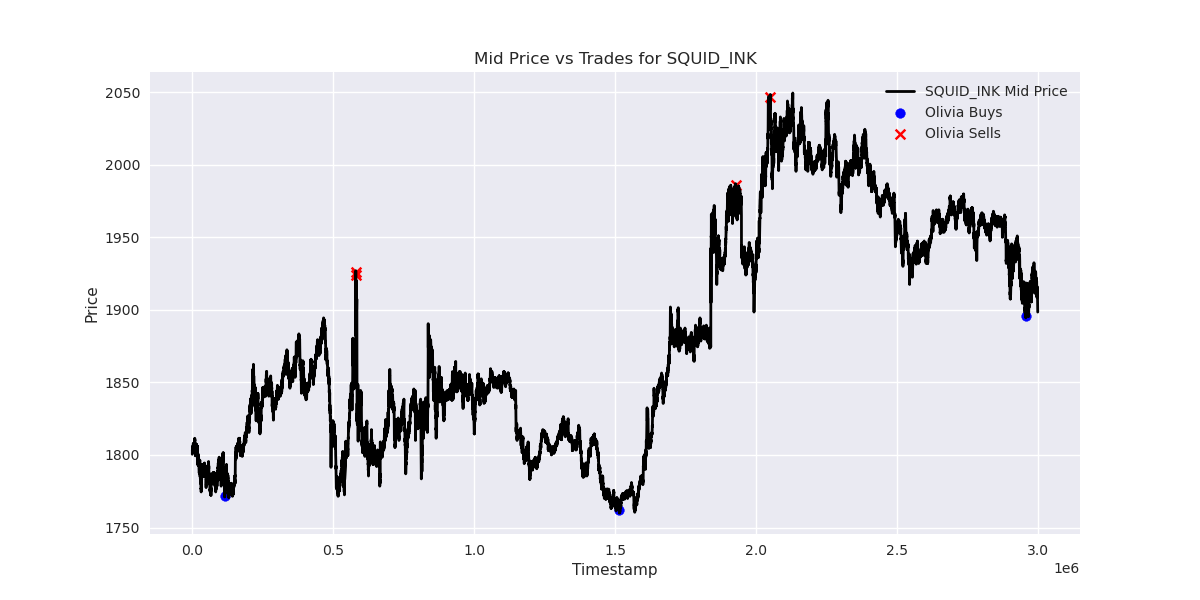

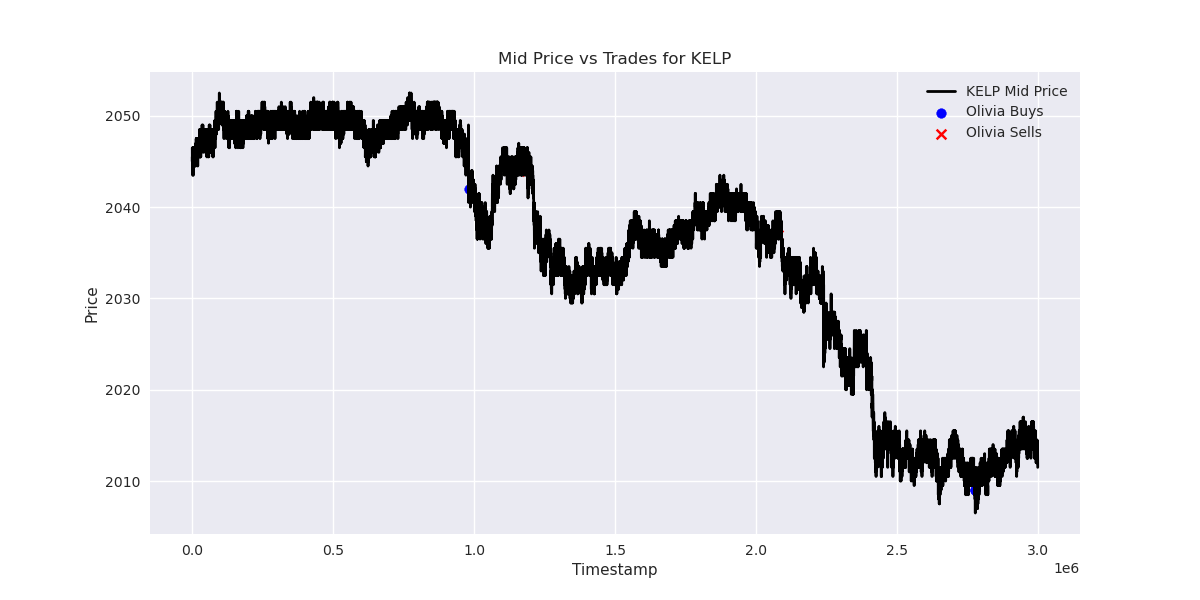

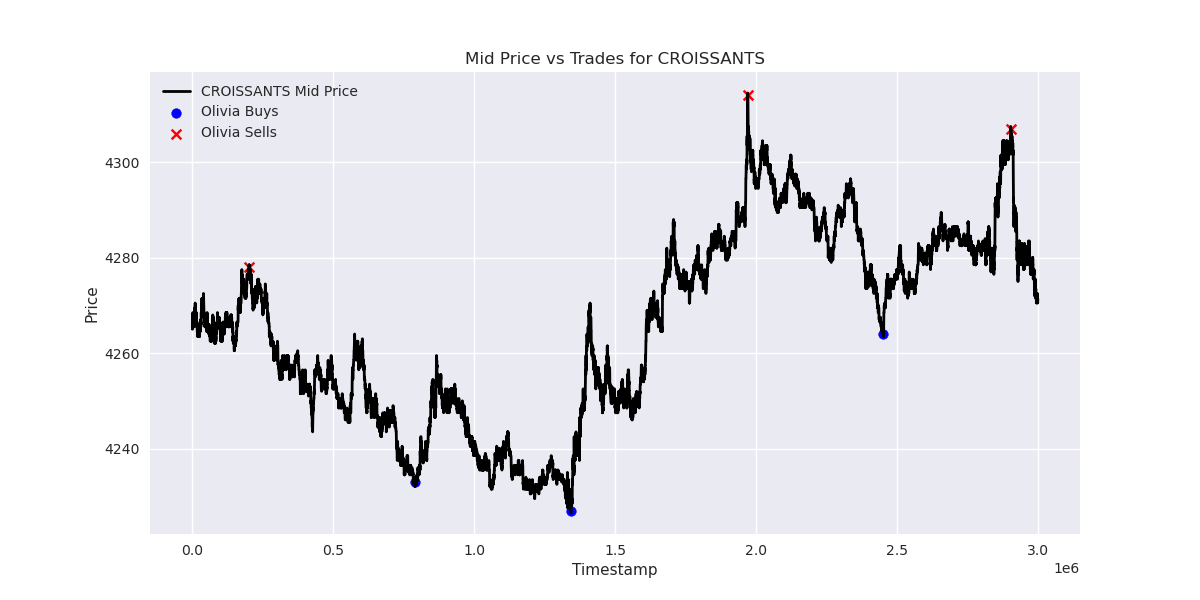

In [10]:

products = df['product'].unique()
for product in products:
    plot_product_trades(df, combined, product, 'Olivia', 'Olivia')


In [7]:
def plot_product_trades2(product_df, trade_df, product_name, buyer, seller):
    # select mid‑price
    product_data = product_df[product_df['product'] == product_name]

    # select only trades where buyer AND seller match
    p_trades = trade_df[
        (trade_df['symbol'] == product_name) &
        (trade_df['buyer']  == buyer) &
        (trade_df['seller'] == seller)
    ]

    # bail out if no trades
    if p_trades.empty:
        return

    plt.figure(figsize=(12, 6))
    
    # plot mid‑price with a lower zorder
    plt.plot(
        product_data['timestamp'],
        product_data['mid_price'],
        label=f'{product_name} Mid Price',
        color='black',
        linewidth=2,
        zorder=1
    )

    # plot trades on top with higher zorder
    plt.scatter(
        p_trades['timestamp'],
        p_trades['price'],
        label=f'{buyer}→{seller} Trades',
        marker='o',
        s=50,            # you can bump size if needed
        edgecolors='white',  # optional, to give dots a border
        linewidths=0.5,
        zorder=2
    )

    # decorate
    plt.title(f"Mid Price vs Trades for {product_name} ({buyer}→{seller})")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
print(buyers_list)

['Caesar', 'Charlie', 'Paris', 'Camilla', 'Pablo', 'Penelope', 'Gary', 'Peter', 'Gina', 'Olivia']


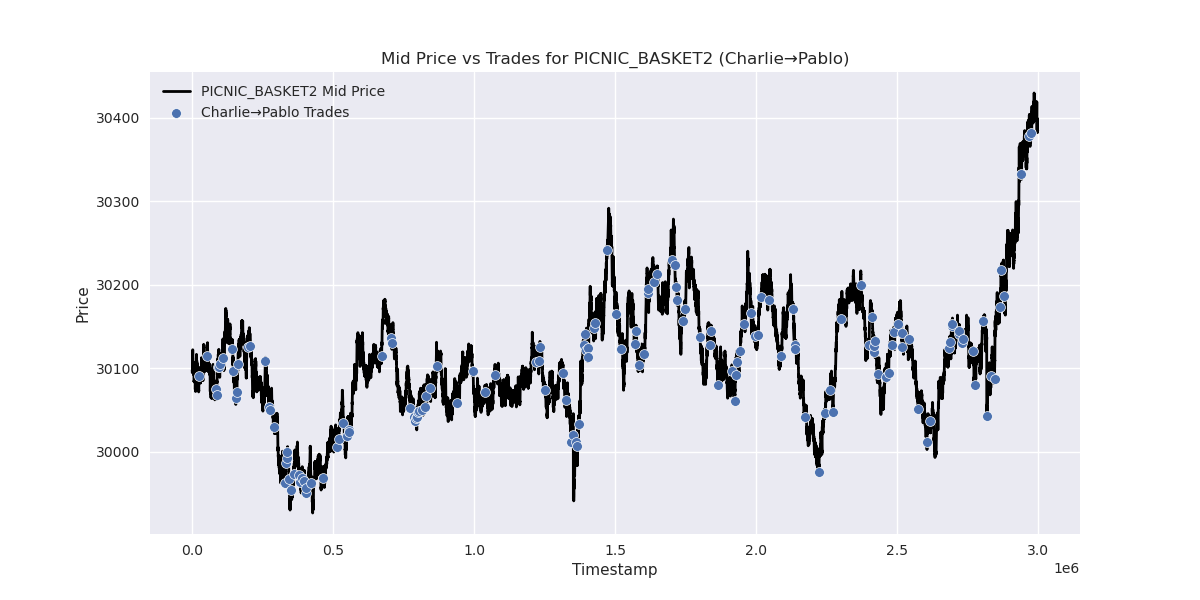

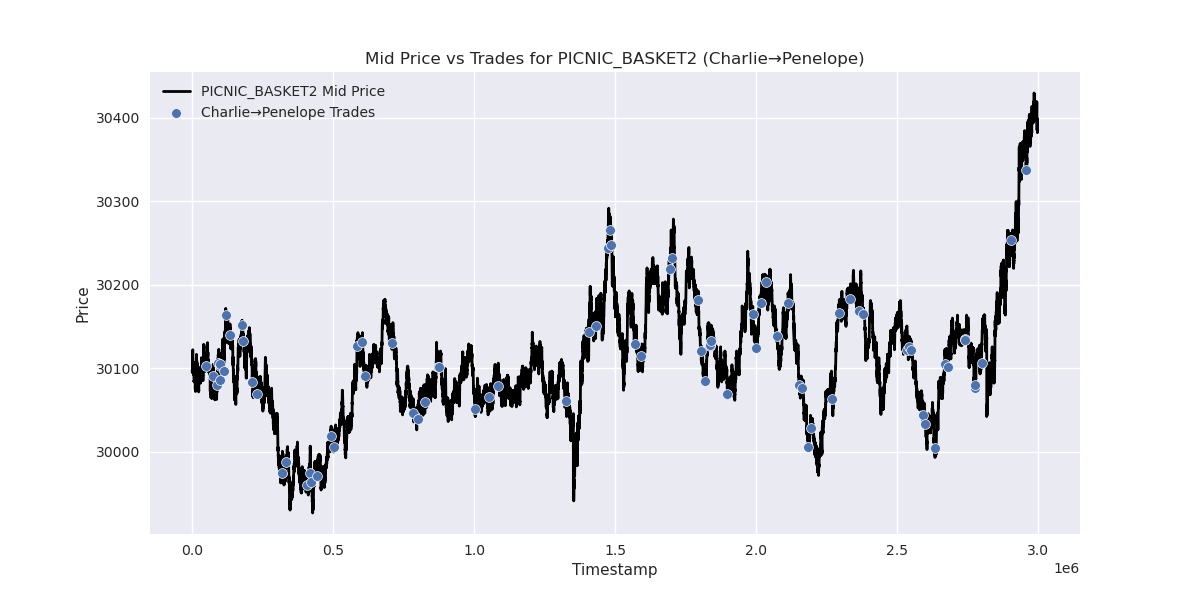

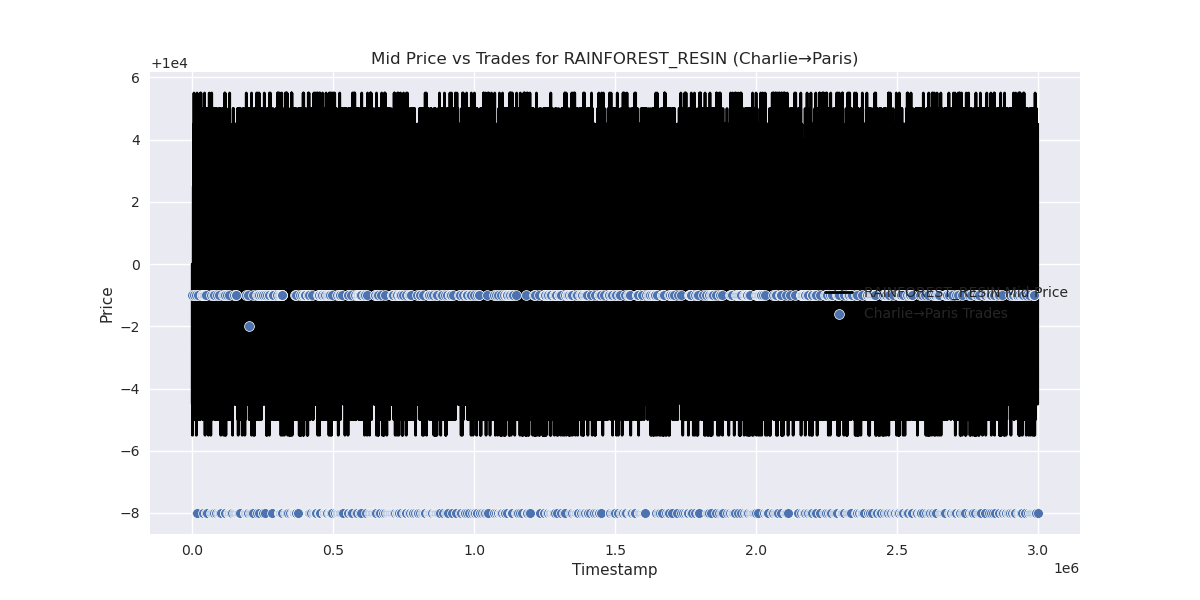

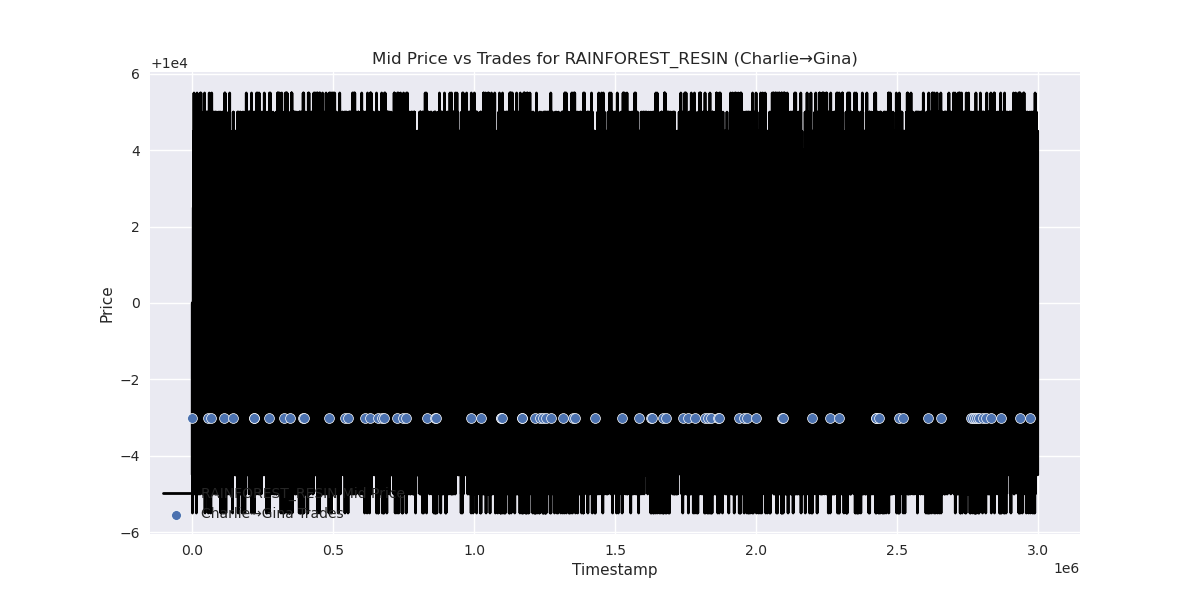

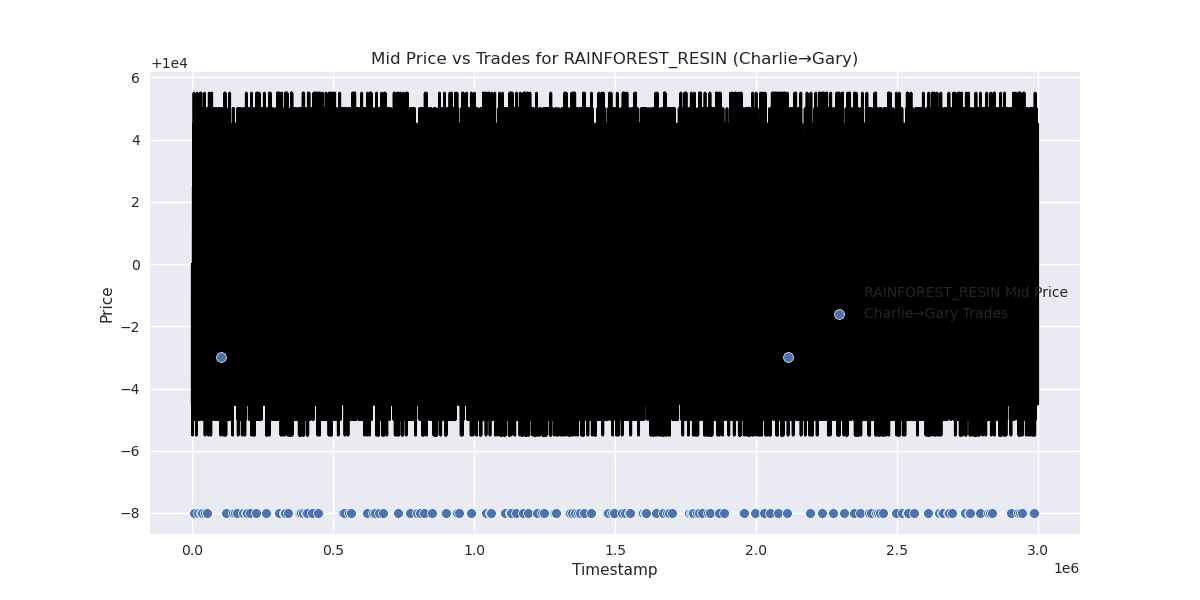

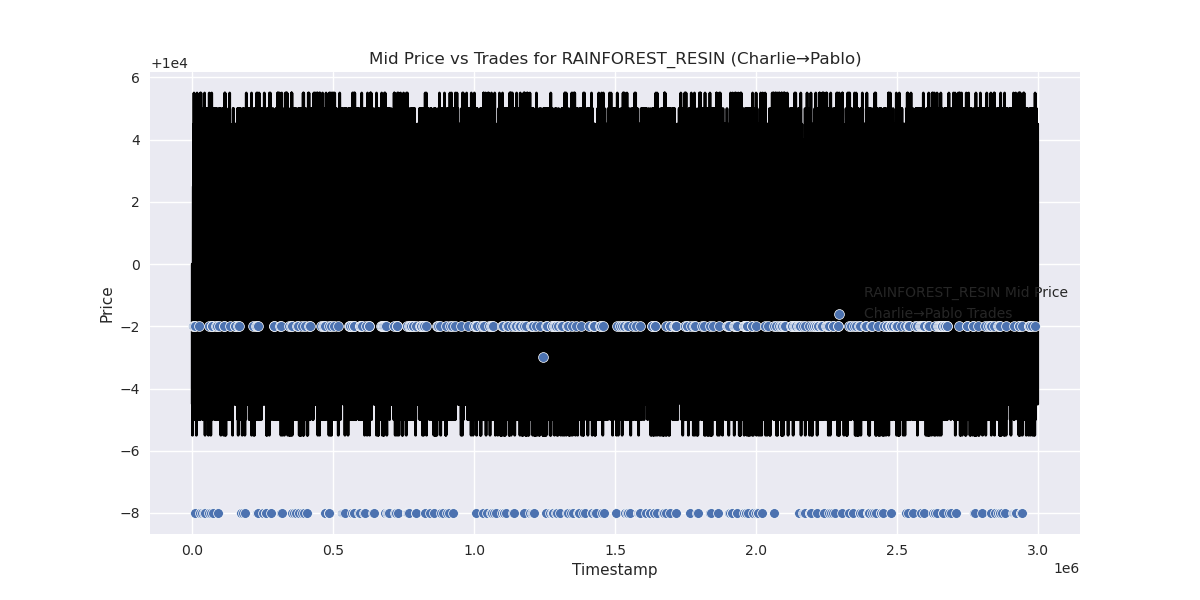

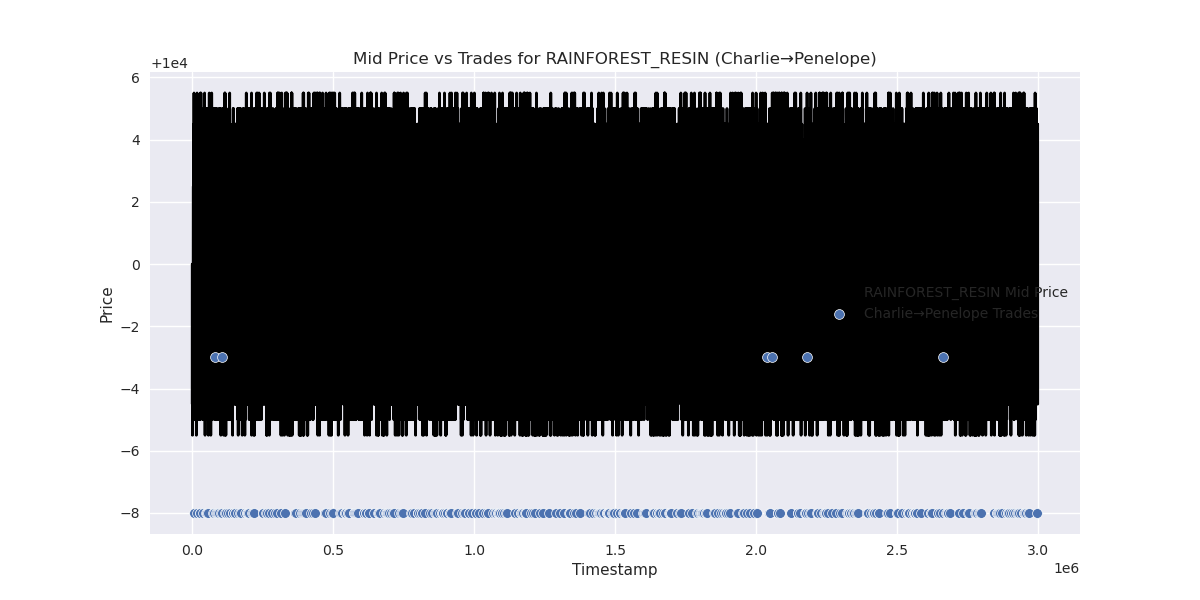

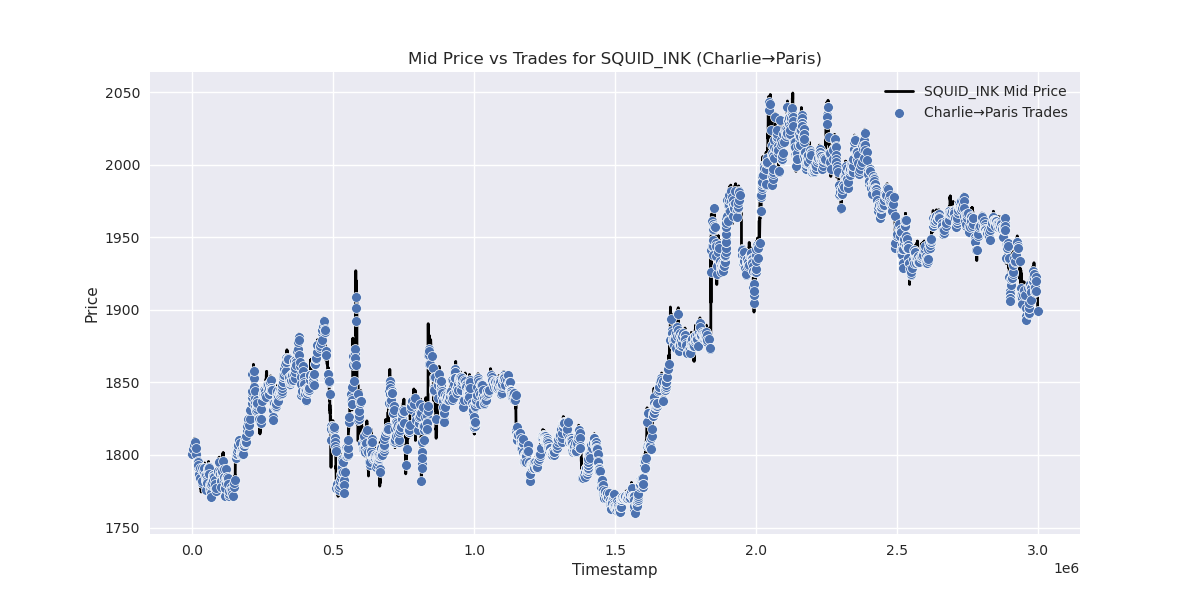

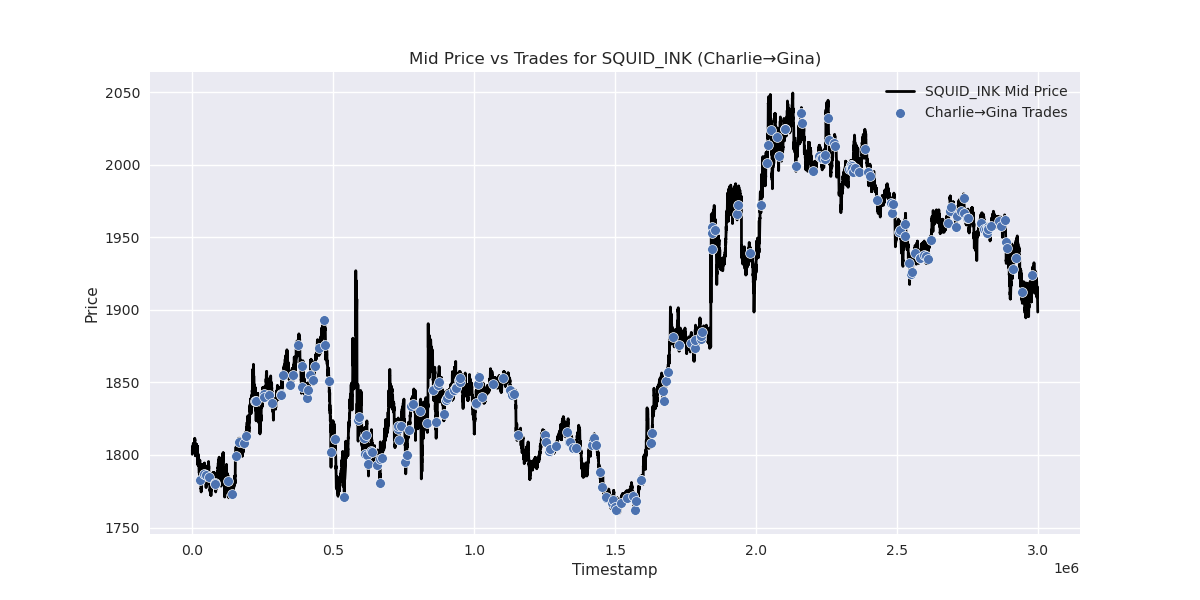

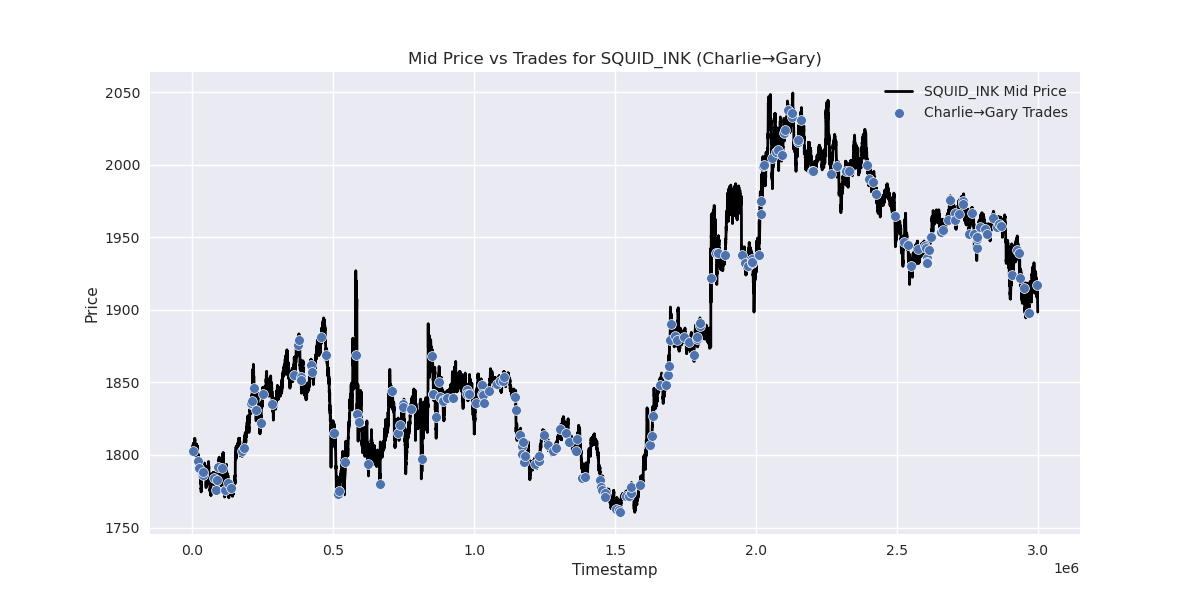

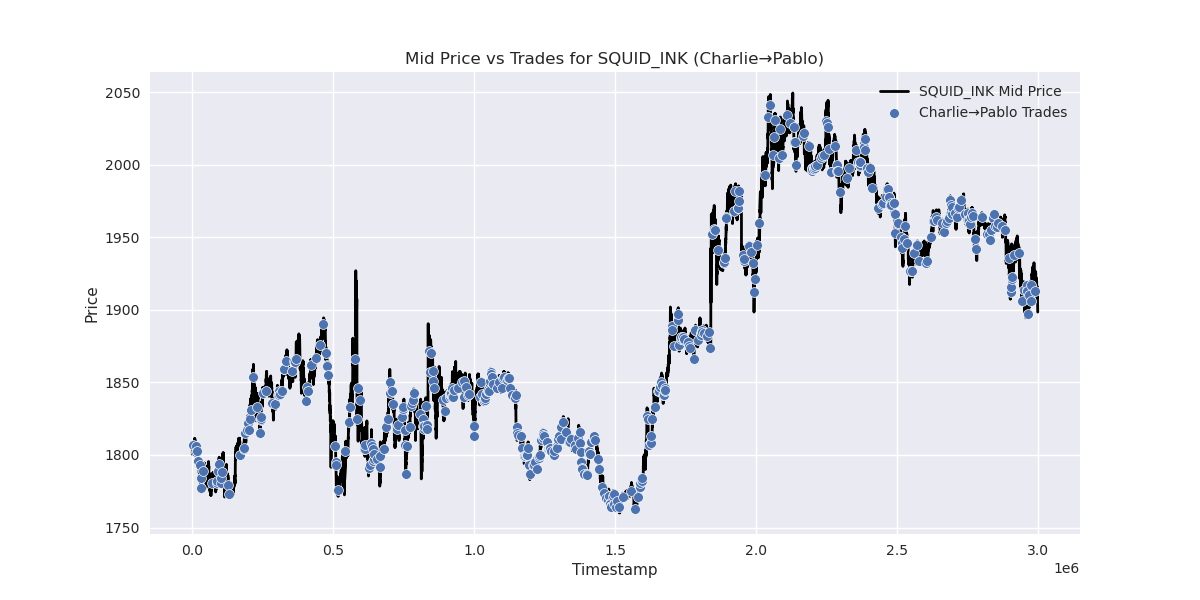

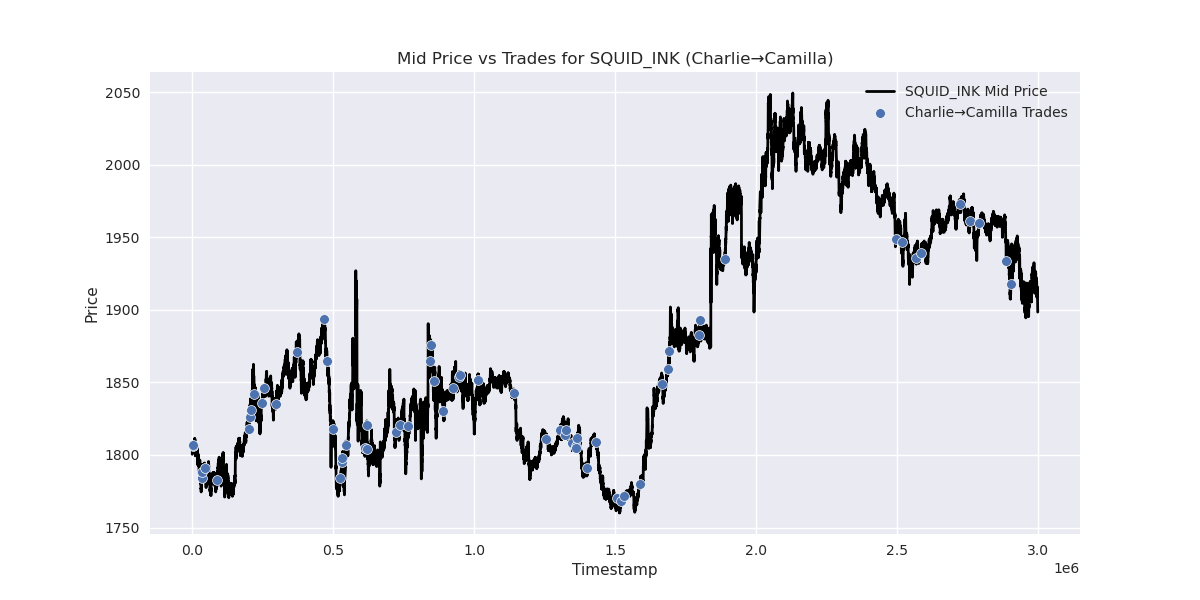

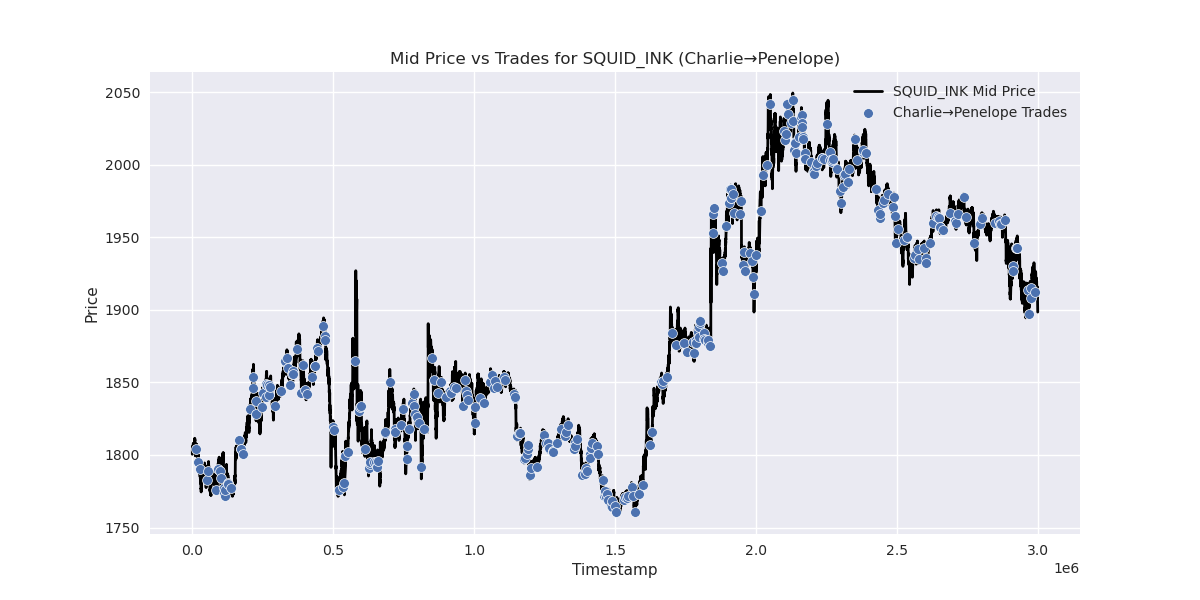

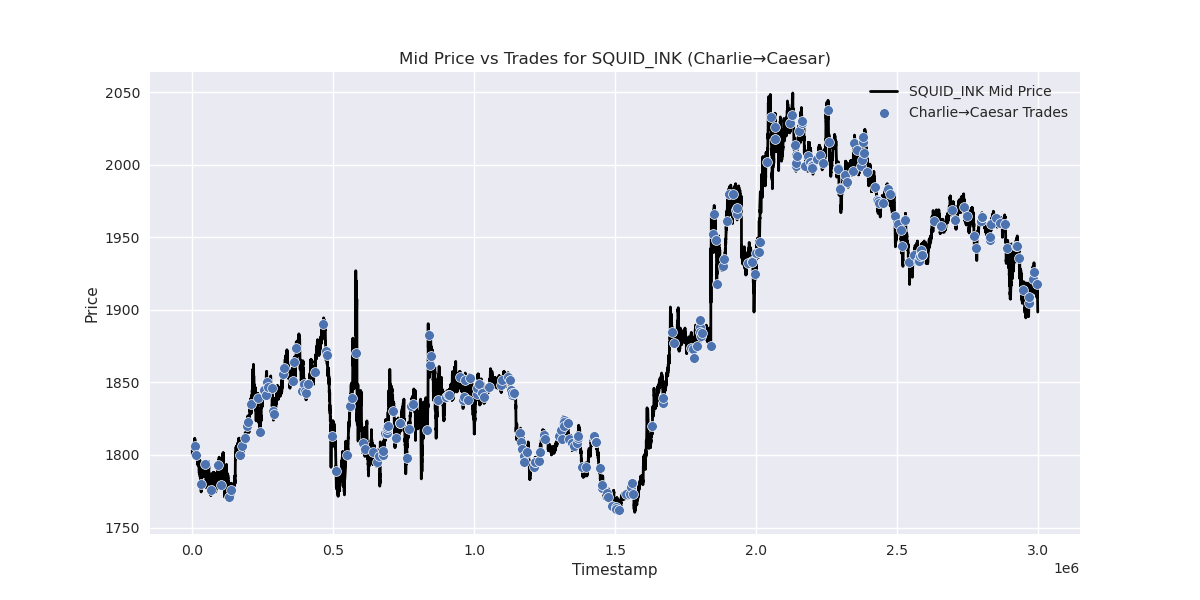

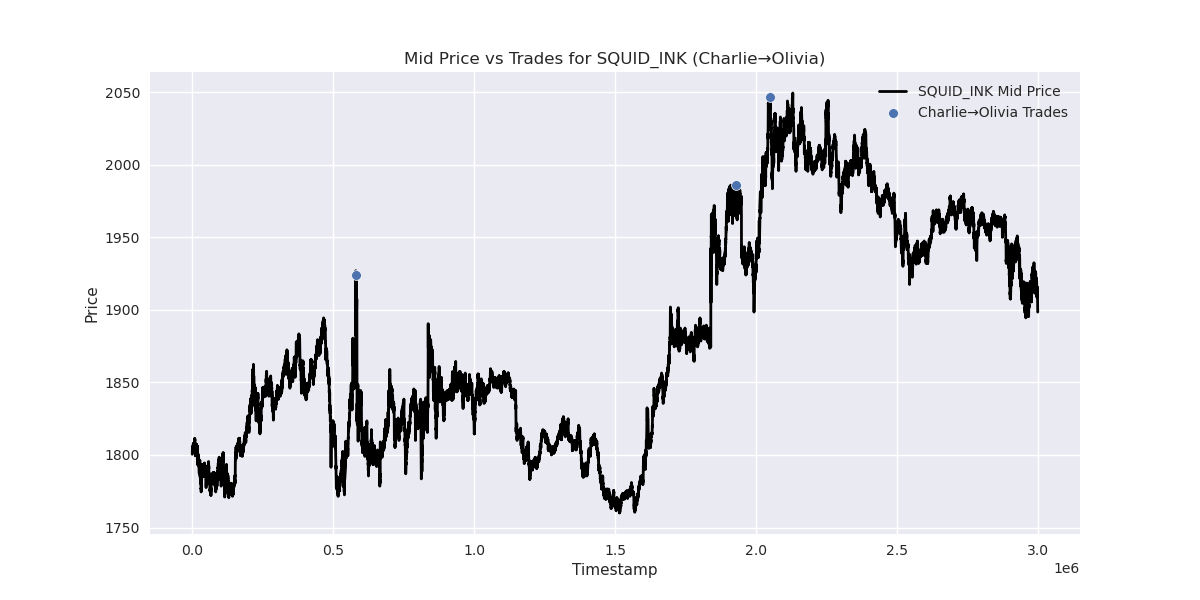

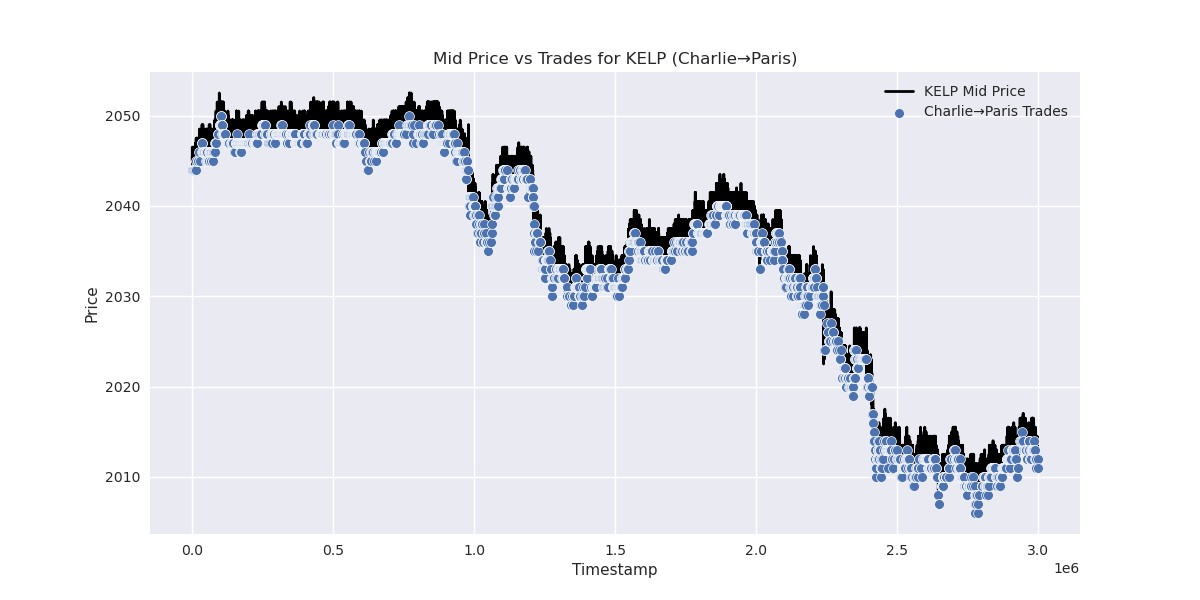

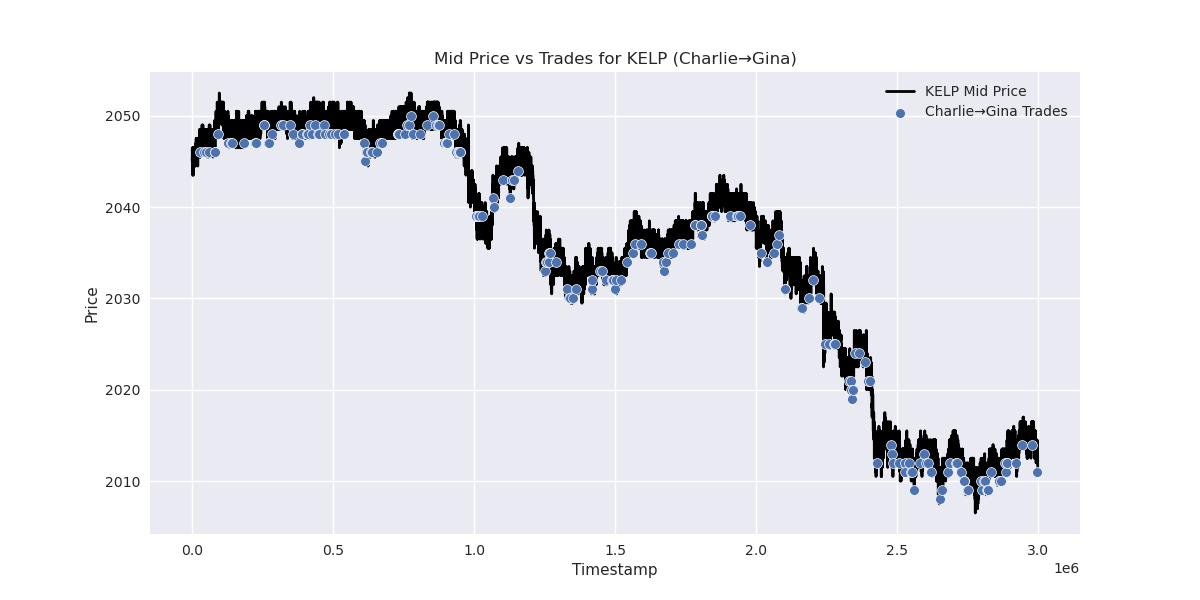

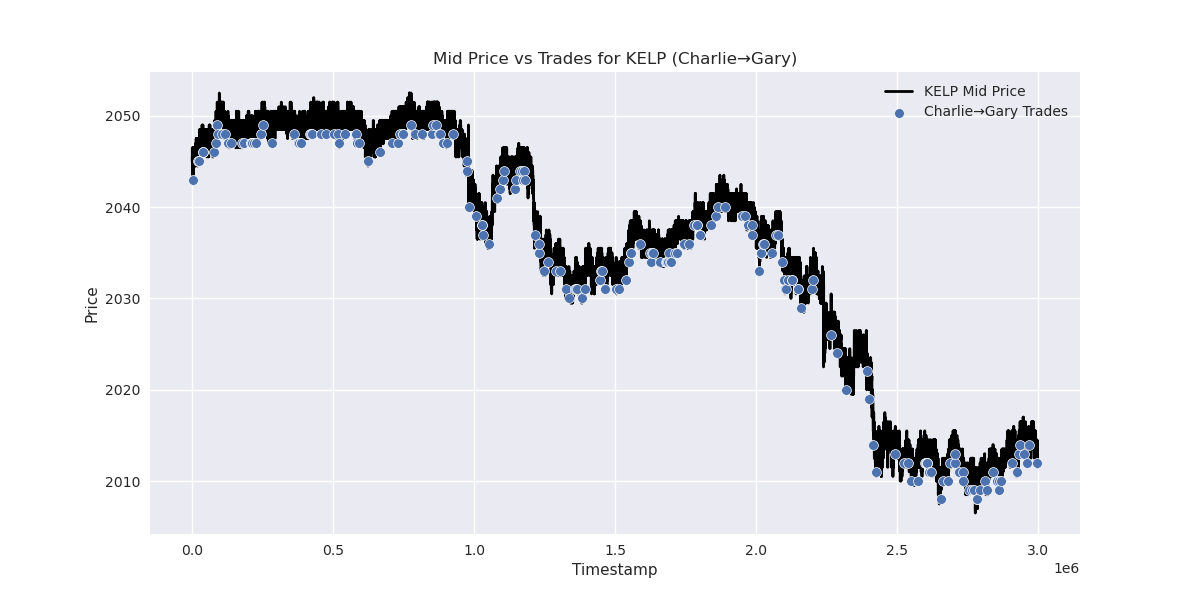

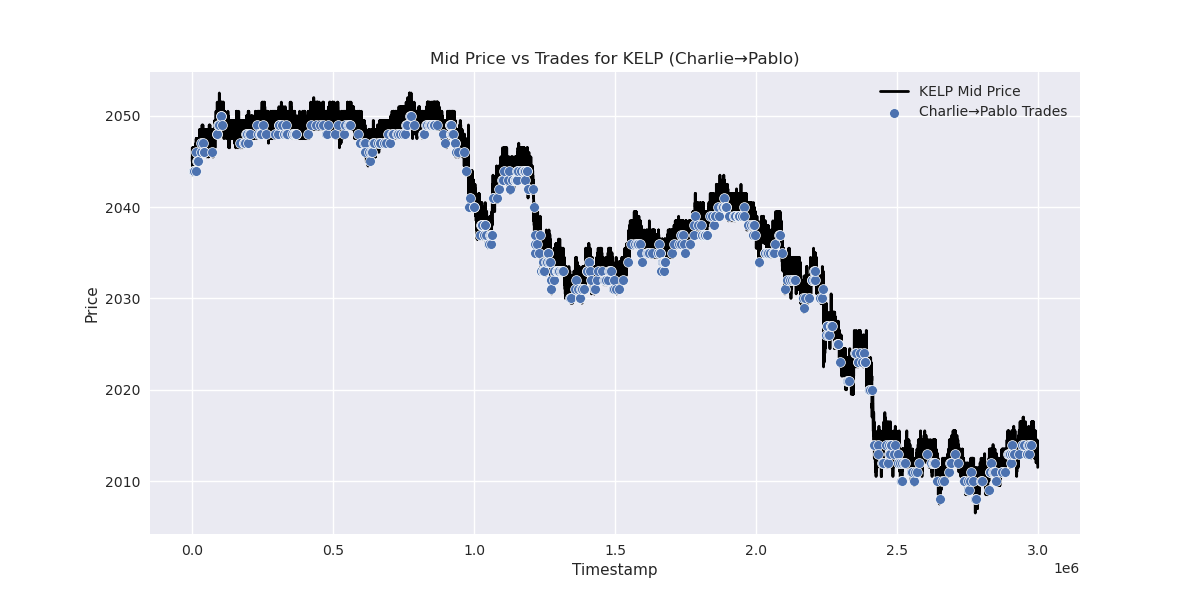

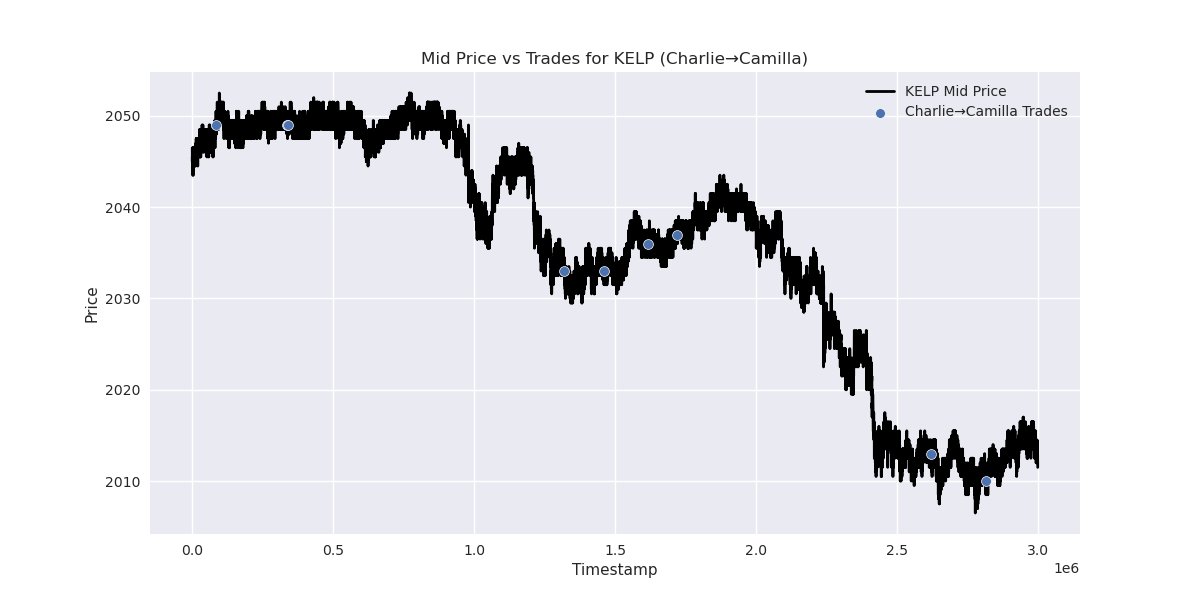

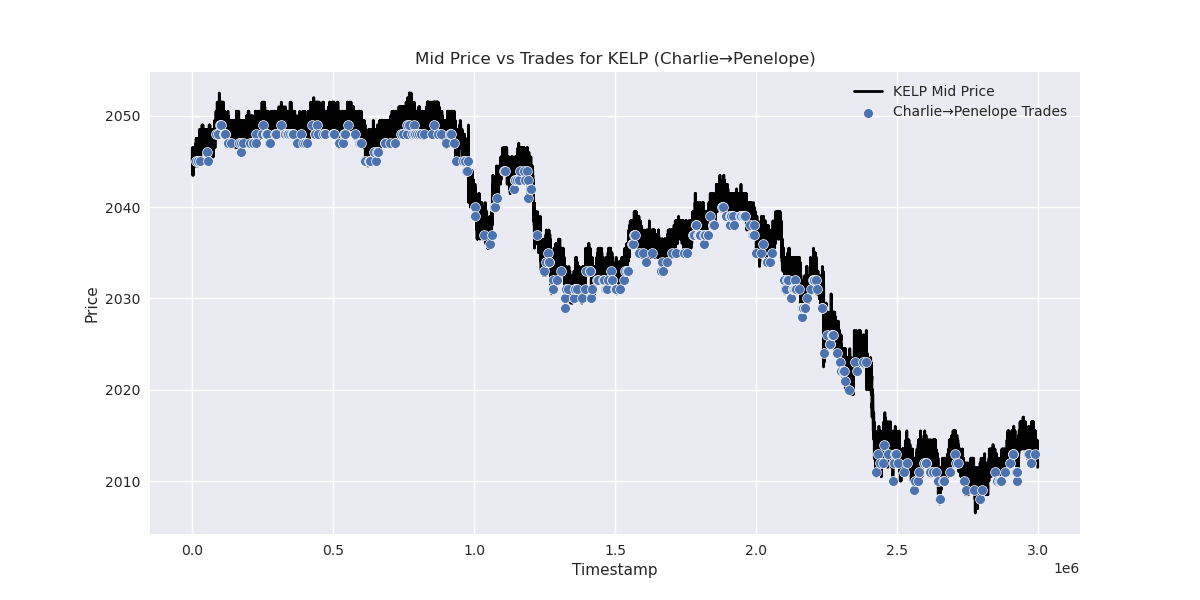

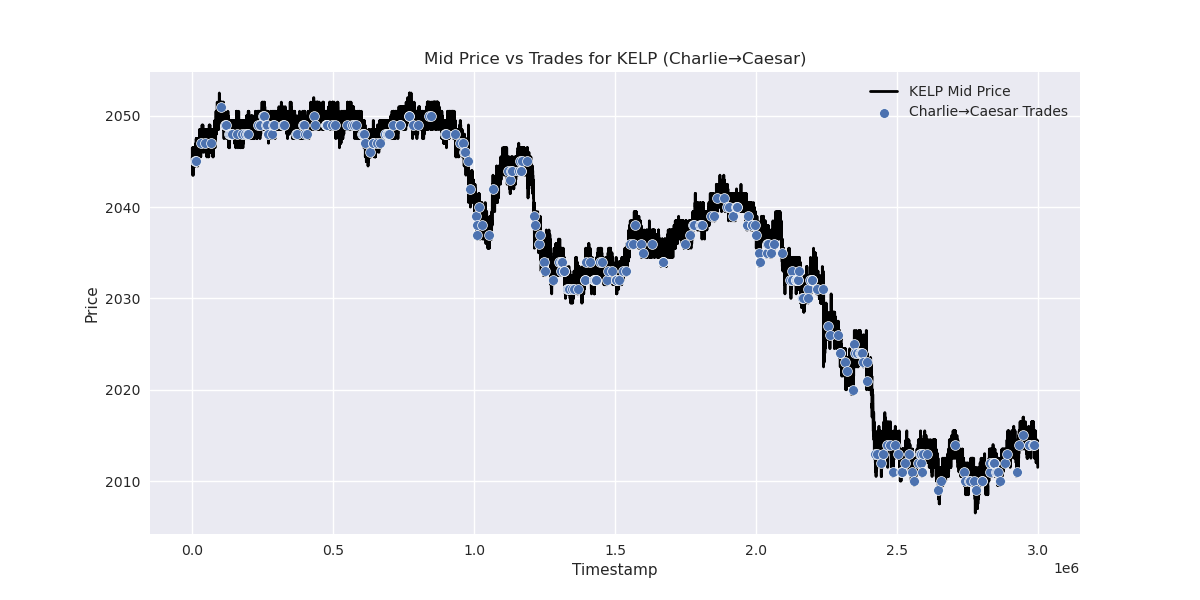

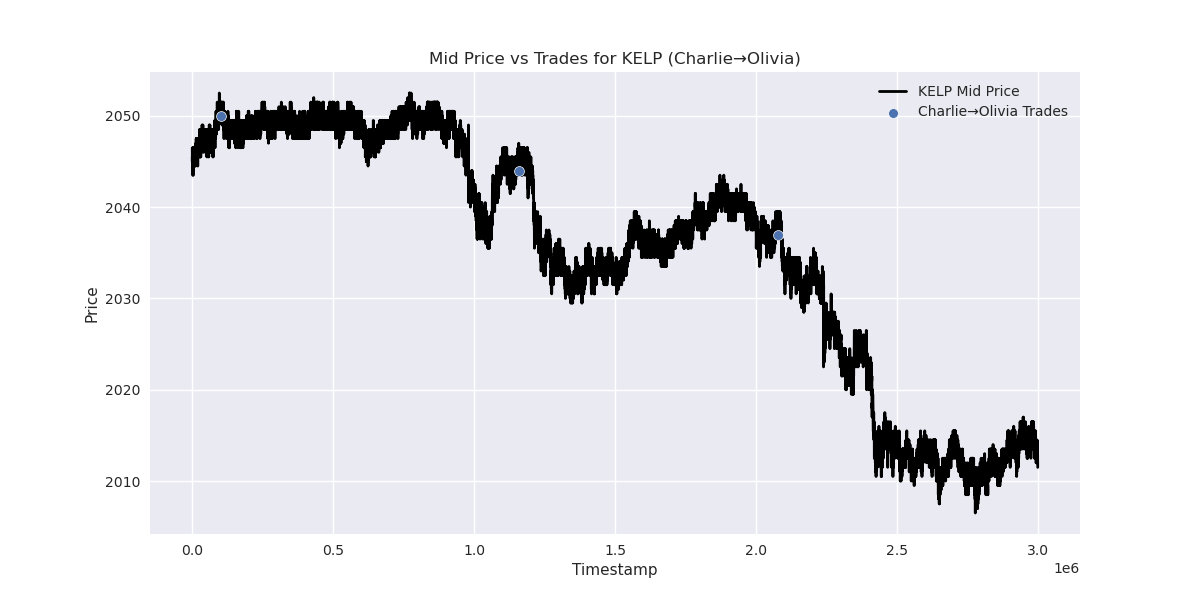

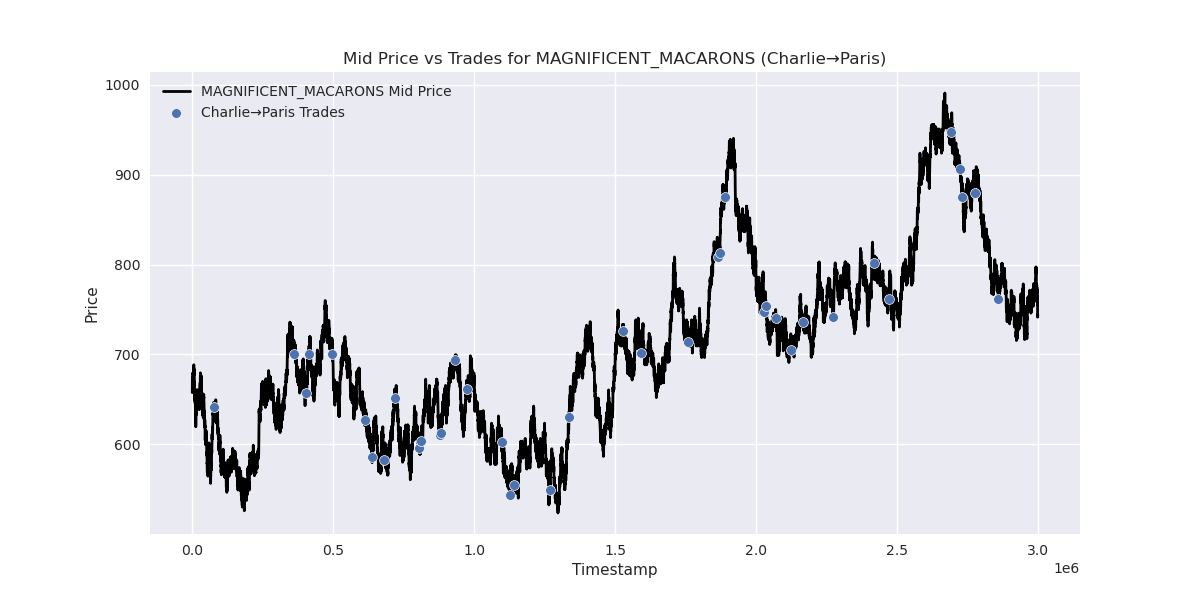

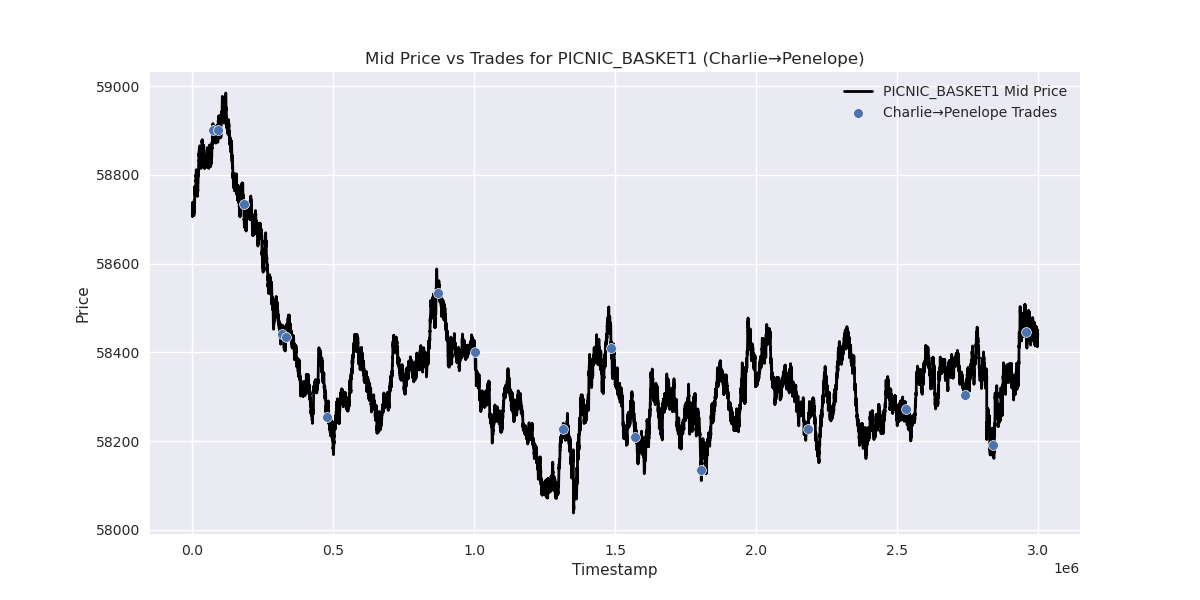

In [16]:
# 1) pick your buyer:
buyer = 'Charlie'

# 2) find all distinct sellers Alice traded with:
sellers = combined.loc[
    combined['buyer'] == buyer, 
    'seller'
].unique()

# 3) now loop over products × those sellers
#    (and skip self‑trades just in case)
for product in df['product'].unique():
    for seller in sellers:
        if seller == buyer:
            continue

        plot_product_trades2(
            product_df=   df,
            trade_df=     combined,
            product_name= product,
            buyer=        buyer,
            seller=       seller
        )
